# Training model on logisitic regression and RF

In [54]:
import sys
sys.path.append('./../../src/')
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(context = 'notebook', font_scale=1.5)
import Data_Loader

In [2]:
X, y = Data_Loader.load_training_data(data_path='final_data/train_with_fam_deck.csv')

## Preprocessing the data

Dropping the unnecessary features

In [3]:
X_v1 = X.drop(['Name', 'Ticket', 'Cabin'], axis=1)

Converting Pclass to a string so it will become one-hot encoded:

In [4]:
X_v1['Pclass'] = X_v1['Pclass'].astype(str)

I need to make dummy variables

In [5]:
X_v2 = pd.get_dummies(X_v1)

Looking at which columns have missing values:

In [27]:
X_v2.isnull().replace(False, np.nan).sum()

Age           177.0
SibSp           NaN
Parch           NaN
Fare            NaN
FamilySize      NaN
Pclass_1        NaN
Pclass_2        NaN
Pclass_3        NaN
Sex_female      NaN
Sex_male        NaN
Embarked_C      NaN
Embarked_Q      NaN
Embarked_S      NaN
Deck_A          NaN
Deck_B          NaN
Deck_C          NaN
Deck_D          NaN
Deck_E          NaN
Deck_F          NaN
Deck_G          NaN
Deck_T          NaN
Deck_UNK        NaN
dtype: float64

So there are only missing values in the Age column

Imputing the ages with the mean:

In [7]:
import sklearn.preprocessing as skl_pre

In [14]:
imputer = skl_pre.Imputer(verbose=1)

X_v3 = pd.DataFrame(imputer.fit_transform(X_v2), columns=X_v2.columns)

In [28]:
X_v3.head(2)

,Age,SibSp,Parch,Fare,FamilySize,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,...,Embarked_S,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Deck_UNK
0,22.0,1.0,0.0,7.2500,2.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,38.0,1.0,0.0,71.2833,2.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
X_v3.isnull().replace(False, np.nan).sum()

Age          NaN
SibSp        NaN
Parch        NaN
Fare         NaN
FamilySize   NaN
Pclass_1     NaN
Pclass_2     NaN
Pclass_3     NaN
Sex_female   NaN
Sex_male     NaN
Embarked_C   NaN
Embarked_Q   NaN
Embarked_S   NaN
Deck_A       NaN
Deck_B       NaN
Deck_C       NaN
Deck_D       NaN
Deck_E       NaN
Deck_F       NaN
Deck_G       NaN
Deck_T       NaN
Deck_UNK     NaN
dtype: float64

Now there are no missing values

## Logistic Model

In [30]:
import sklearn.linear_model as skl_lm
import sklearn.model_selection as skl_ms

In [52]:
lr_gs_clf = skl_ms.GridSearchCV(estimator=skl_lm.LogisticRegression(),
                                param_grid = [{'penalty': ['l1'], 'C':np.logspace(-5,5, num=30)},
                                             {'penalty': ['l2'], 'C':np.logspace(-5,5, num=30)}],
                               cv = 5)
lr_gs_clf.fit(X_v3, y);

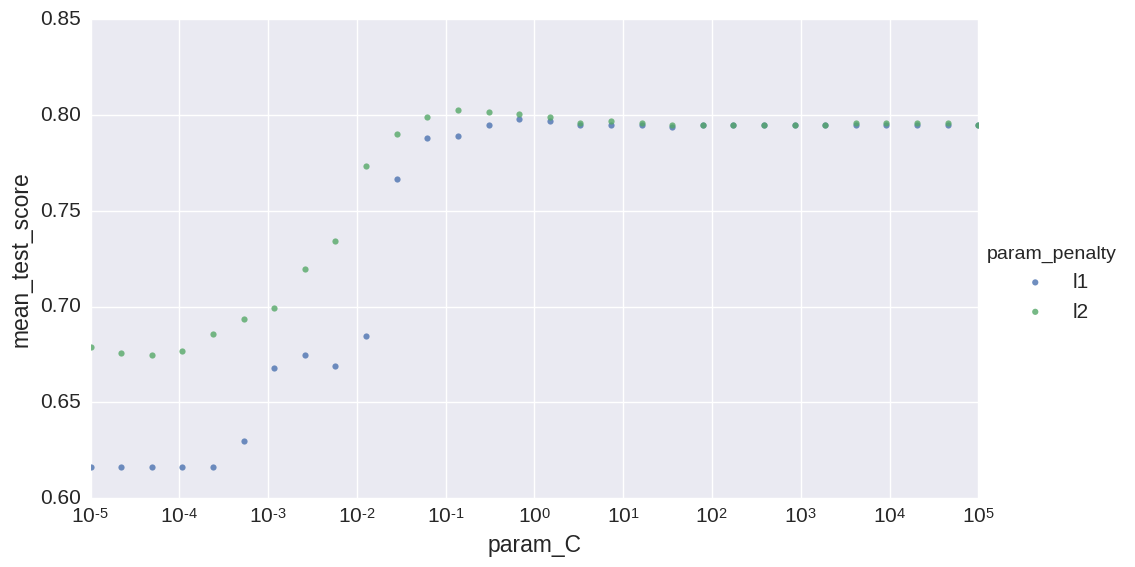

In [67]:
lr_cv_results = pd.DataFrame(lr_gs_clf.cv_results_)

sns.lmplot(x = 'param_C', y = 'mean_test_score', 
           data = lr_cv_results, 
           fit_reg=False, hue = 'param_penalty', logx=True,
          size = 6, aspect=1.7)
ax = plt.gca()
ax.set_xlim([1e-5,1e5])
ax.set_xscale('log')

This shows that our best test score occurs at a C value of 0.1. It only barely achieves a 0.8 score though:

## Random Forest

In [58]:
import sklearn.ensemble as skl_ensemble

In [59]:
rf_gs_clf = skl_ms.GridSearchCV(estimator=skl_ensemble.RandomForestClassifier(),
                                param_grid = [{'n_estimators':[10, 100, 1000], 'max_depth':[None, 2, 4, 8, 16, 32], 'min_samples_split':[2, 4]}],
                               cv = 5,
                               n_jobs = 6)
rf_gs_clf.fit(X_v3, y);

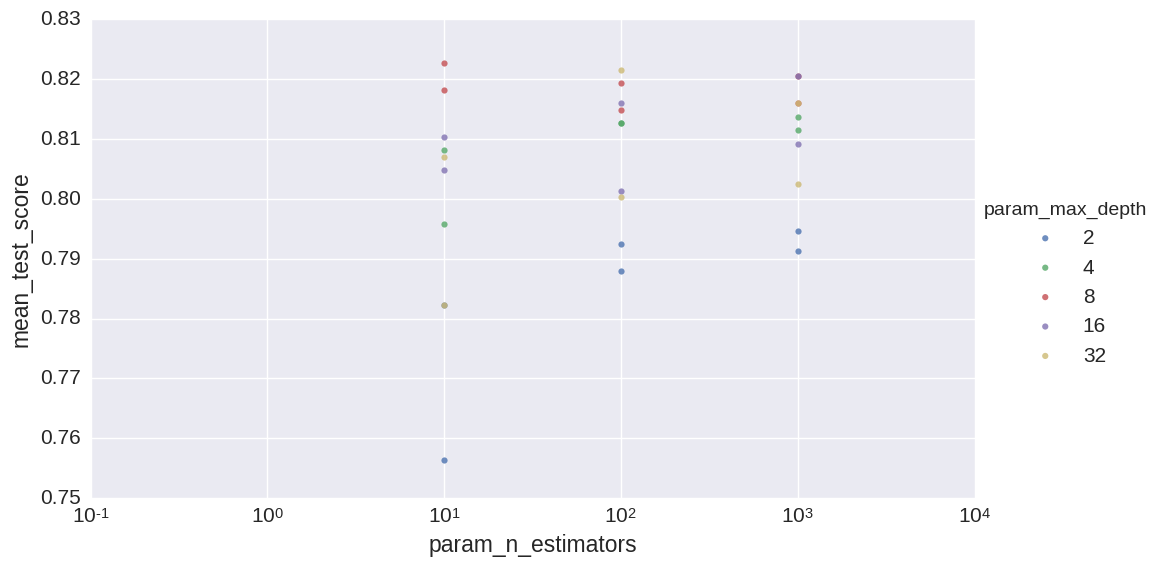

In [65]:
rf_cv_results = pd.DataFrame(rf_gs_clf.cv_results_)

sns.lmplot(x = 'param_n_estimators', y = 'mean_test_score', 
           data = rf_cv_results, 
           fit_reg=False, hue = 'param_max_depth', logx=True,
          size = 6, aspect=1.7)
ax = plt.gca()
ax.set_xlim([1e-1,1e4])
ax.set_xscale('log')

These get a better score than with logistic regression. I will use 100 estimators with 32 max_depth